With this martingale strategy, this is most helpful when running a strategy on a low vol underlying strategy. Then with this low strategy level target vol, you can run a martingale strategy that enhances the skew and CAGR of the strategy. This enhances the ratio of return to drawdown and generally makes strategies more useful for traders.

Works very well for low vol because this provides flexibility to create larger and larger scalars.

A future implementation of this could measure the ex-ante 1-day or 1-period autocorreltion. If positive, then take the opposite and martingale_scalar * prev_gnv positions. If negative autocorrelation, then take the same position at scalar*prev_gnv. 

Essentially, we want to be able to capture scenarios when the martingale works. This would work in the prescence of autocorrelation that we can capture. Perhaps we can generate a regime fliter for this betting strategy where it's only enacted when there's statistically significant trailing autocorrelation. (measured from Durbin-Watson, Portmanteau, or a rolling-lagged-regression)

This can also be captured by If noise dominates, then martingale expands the volatility drag penalty and martingales perform worse than normal - empirically simulations show that the tradeoff between aggressiveness and drag comes around a noise ratio of 50. For daily returns, the Sharpe can be approximated μ / σ ∗ 16, and a noise ratio corresponds to Sharpe of approximately 1 / 50 ∗ 16 = 0.32. When Sharpe is lower than this threshold the volatility drag dominates the benefit of wealth maximization vis-`a-vis aggressiveness.

In [13]:
from quantlib.alphas.formulaic_alphas import alpha_004 
import quant_tools.performance_analysis as pa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
alpha = alpha_004.alpha_004()

Loading cache from C:\Users\marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\quantlib\database\cache\russell_3000\russell_3000_cache.pickle
Loading cache from C:\Users\marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\quantlib\database\cache\russell_3000\adj_close_returns.pickle
Getting formulaic alpha for AAPL
Getting formulaic alpha for MSFT
Getting formulaic alpha for AMZN
Getting formulaic alpha for GOOGL
Getting formulaic alpha for GOOG
Getting formulaic alpha for NVDA
Getting formulaic alpha for XOM
Getting formulaic alpha for TSLA
Getting formulaic alpha for UNH
Getting formulaic alpha for JNJ
Getting formulaic alpha for JPM
Getting formulaic alpha for V
Getting formulaic alpha for META
Getting formulaic alpha for HD
Getting formulaic alpha for PG
Getting formulaic alpha for CVX
Getting formulaic alpha for MA
Getting formula

TypeError: 'Series' object is not callable

In [3]:
returns = (alpha.alpha_model_returns*-1).iloc[4000:]

In [46]:
N_SIMS = 100
skews = np.empty(shape=(N_SIMS))
sharpes = np.empty(shape=(N_SIMS))
cagrs = np.empty(shape=(N_SIMS))
sortinos = np.empty(shape=(N_SIMS))
martins = np.empty(shape=(N_SIMS))
vols = np.empty(shape=(N_SIMS))
martingale_scalars = {}
cum_rets = {}
_martingale_returns = {}

skews_standard = np.empty(shape=(N_SIMS))
sharpes_standard = np.empty(shape=(N_SIMS))
cagrs_standard = np.empty(shape=(N_SIMS))
sortinos_standard = np.empty(shape=(N_SIMS))
martins_standard = np.empty(shape=(N_SIMS))
vols_standard = np.empty(shape=(N_SIMS))
cum_rets_standard = {}
_standard_returns = {}

for n in range(N_SIMS):
    try:
        start_i = np.random.random_integers(low=3000, high=12000-252*5)
        tmp_rets = returns.iloc[start_i:start_i+252*5] / 2
        martingale_scalar = pd.Series(np.ones(shape=(len(tmp_rets))), index=tmp_rets.index)
        for i, (date, ret) in enumerate(tmp_rets.items()):
            if i == (len(tmp_rets)-1):
                break
            if ret < 0:
                new_scalar = 1.3 * martingale_scalar.iloc[i]
                martingale_scalar.iloc[i+1] = new_scalar if new_scalar < 6 else 6
            if ret >= 0:
                martingale_scalar.iloc[i+1] = 1

        martingale_returns = (martingale_scalar * tmp_rets).dropna()
        
        # Martinglate data
        _martingale_returns[n] = martingale_returns 
        martingale_scalars[n] = martingale_scalar
        performance_summary = pa.performance_summary(_martingale_returns[n])
        skews[n] = performance_summary.loc['Skew']
        sharpes[n] = performance_summary.loc['Sharpe Ratio']
        cagrs[n] = performance_summary.loc['CAGR']
        sortinos[n] = performance_summary.loc['Sortino Ratio']
        martins[n] = performance_summary.loc['Martin (Ulcer) Ratio']
        vols[n] = performance_summary.loc['Vol']
        cum_rets[n] = pa.cumulative_returns(martingale_returns).reset_index(drop=True)

        # Standard data
        _standard_returns[n] = tmp_rets.dropna()
        performance_summary = pa.performance_summary(_standard_returns[n])
        skews_standard[n] = performance_summary.loc['Skew']
        sharpes_standard[n] = performance_summary.loc['Sharpe Ratio']
        cagrs_standard[n] = performance_summary.loc['CAGR']
        sortinos_standard[n] = performance_summary.loc['Sortino Ratio']
        martins_standard[n] = performance_summary.loc['Martin (Ulcer) Ratio']
        vols_standard[n] = performance_summary.loc['Vol']
        cum_rets_standard[n] = pa.cumulative_returns(tmp_rets.dropna()).reset_index(drop=True)

    except ValueError as err:
        print(ValueError)

cum_rets = pd.DataFrame(cum_rets)
cum_rets_standard = pd.DataFrame(cum_rets_standard)

statistic_list = {"skews": skews, "sharpes": sharpes, "cagrs": cagrs, "sortinos": sortinos, "martins": martins, "vols": vols}
statistic_list_standard = {"skews": skews_standard, "sharpes": sharpes_standard, "cagrs": cagrs_standard, "sortinos": sortinos_standard, "martins": martins_standard, "vols": vols_standard}

C:\Users\marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:23: DeprecationWarning: This function is deprecated. Please call randint(3000, 10740 + 1) instead


<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'ValueError'>
<class 'Value

<AxesSubplot:>

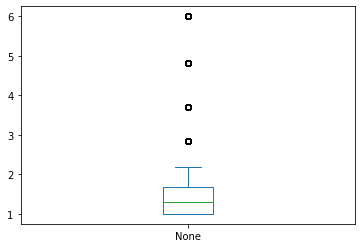

In [47]:
pd.Series(pd.DataFrame(martingale_scalars).to_numpy().flatten()).plot(kind='box')

In [11]:
(cum_rets.iloc[:, 0:100]-cum_rets.iloc[:, 0:100].cummax()).min().min()

-0.21416152376298392

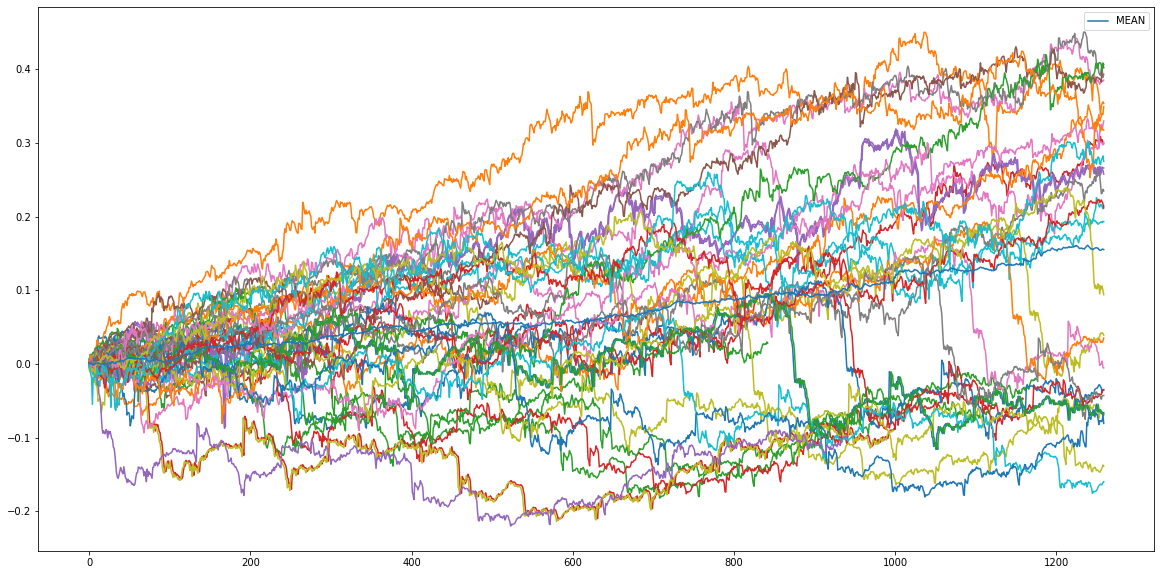

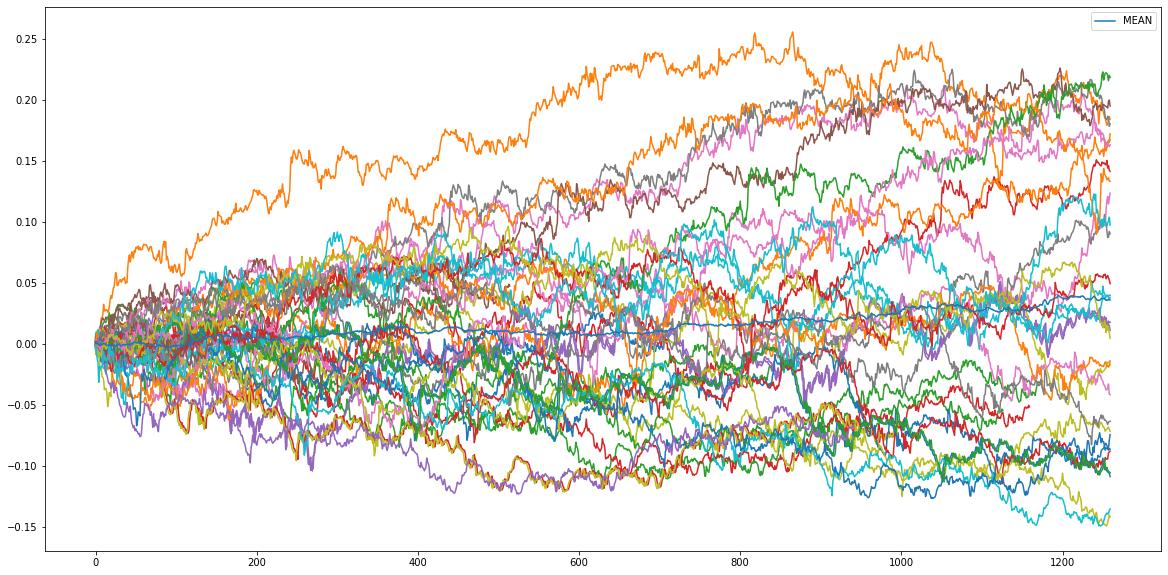

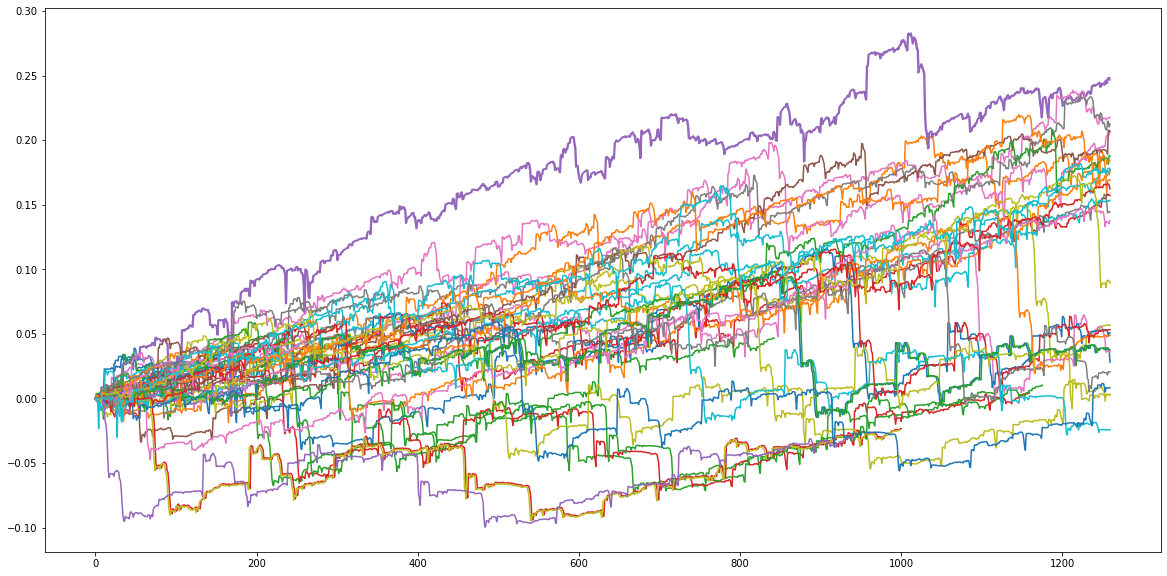

In [48]:
cum_rets.plot(legend=False, figsize=(20, 10))
cum_rets.mean(axis=1).rename('MEAN').plot(legend=True, figsize=(20, 10))
plt.show()

cum_rets_standard.plot(legend=False, figsize=(20, 10))
cum_rets_standard.mean(axis=1).rename('MEAN').plot(legend=True, figsize=(20, 10))
plt.show()

diff = (cum_rets - cum_rets_standard)
diff.plot(legend=False, figsize=(20, 10))
plt.show()

In [15]:
def get_pct_negative(df):
    pct_neg = len(df.iloc[-1].where(df.iloc[-1] < 0).dropna()) / len(df.iloc[-1])
    return len(df.iloc[-1].where(df.iloc[-1] < 0).dropna()) / len(df.iloc[-1])

In [49]:
get_pct_negative(cum_rets), get_pct_negative(cum_rets_standard), get_pct_negative(diff)

(0.2, 0.24, 0.02)

In [50]:
sr = (pd.Series(statistic_list['sharpes']) > 200)
pd.Series(statistic_list['sharpes']).mask()

TypeError: mask() missing 1 required positional argument: 'cond'

In [51]:
pd.Series(statistic_list['sharpes']).iloc[7]

-0.027515599783369028

In [52]:
pd.Series(statistic_list['sharpes']) 

0     0.274000
1     0.892000
2    -0.023510
3    -0.021045
4    -0.105000
        ...   
95    1.127000
96   -0.018573
97   -0.024830
98    0.281000
99    0.560000
Length: 100, dtype: float64

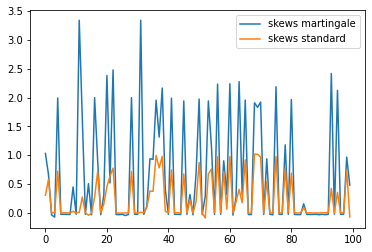

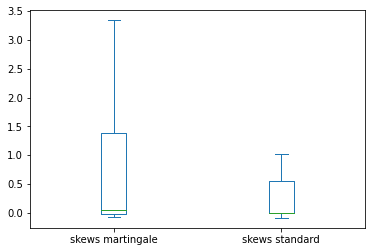

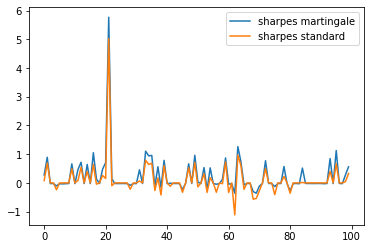

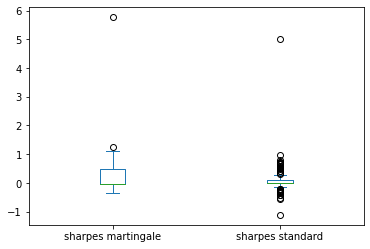

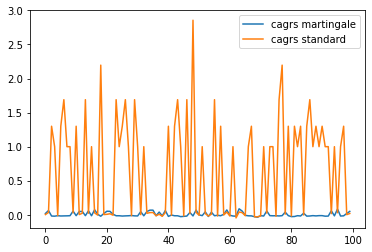

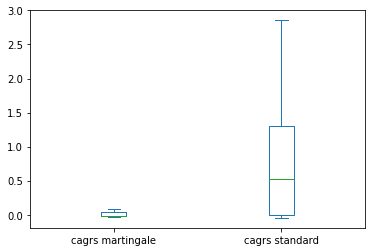

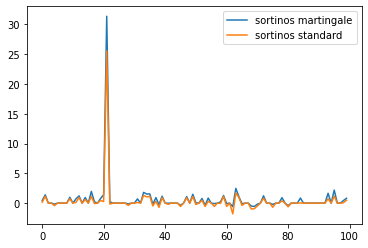

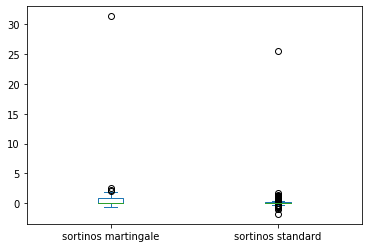

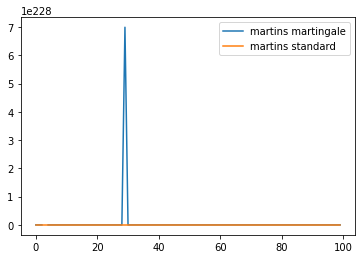

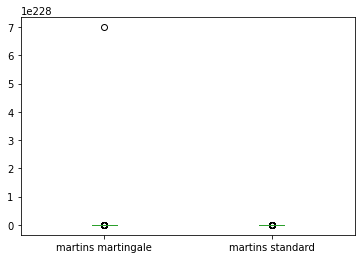

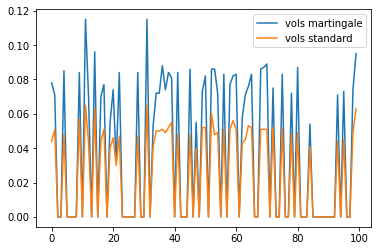

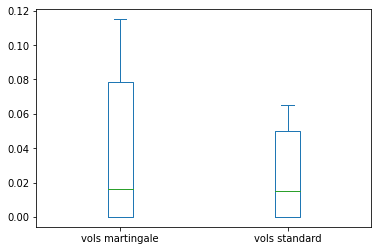

In [53]:
def summary_statistics(name):
    df = pd.concat([
        pd.Series(statistic_list[name], name=name + " martingale"),
        pd.Series(statistic_list_standard[name], name=name + " standard")
    ], axis=1)
    df.plot()
    df.plot(kind="box")
    plt.show()

for name in statistic_list.keys():
    summary_statistics(name)

In [909]:
0.163 / 0.112, 0.214/0.166

(1.4553571428571428, 1.289156626506024)

In [790]:
pa.performance_summary(pd.concat([martingale_returns.rename('martingale_returns'), tmp_rets], axis=1))

,martingale_returns Performance Summary,scaled Performance Summary
Sharpe Ratio,1.281,1.189
Drift Adjusted Sharpe Ratio,0.041,0.053
CAGR,0.217,0.135
Vol,0.163,0.112
Sortino Ratio,1.781,1.591
Martin (Ulcer) Ratio,4.089,2.698
Omega Ratio,1.187,1.107
RR Ratio,1.288,1.229
Win Rate,0.559,0.559
Skew,1.324,-0.414
